# Classification of readmission within first 30 days from history of diabetes patient's encounters.

Author: Cesar Gustavo Seminario Calle


## Table of content

- [Definitions](#Definitions)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Instance information](#Instance-information)
    - [Null values](#Null-values)
    - [Distributions](#Distributions)
        - [Demographic Distributions](#Demographic-Distributions)
        - [Continuous and Discrete variables](#Continuous-and-Discrete-variables)
    - [Correlations and Variance](#Correlations-and-Variance)
    - [Readmission](#Readmission)
        - [Binary variables vs Readmission](#Binary-variables-vs-Readmission)
- [Data Preparation](#Data-Preparation)
    - [Encoding outcome](#Encoding-outcome)
    
- [Feature Engineering](#Feature-Engineering)
    - [transform age](#transform-age)
    - [encoding ordinal variables](#encoding-ordinal-variables)
- [Build Model](#Build-Model)
    - [Train Test Split](#Train-Test-Split)
    - [Training](#Training)
    - [Tunning](#Tunning)
- [Fairness Analysis](#Fairness-Analysis)
    - [Demographic Bias](#Demographic-Bias)
    - [False Positive Rate - Race](#False-Positive-Rate(Race))

In [1]:
import pandas as pd
import numpy as np
import mlflow as ml
import warnings

import seaborn as sns
import matplotlib.pyplot as plt  

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore')

---

In [2]:
dfdiabetes = pd.read_csv("../data/raw/dataset_diabetes/diabetic_data.csv", na_values = ['?'])
dfidmap = pd.read_csv("../data/raw/dataset_diabetes/IDs_mapping.csv", header = None)
dfdescription = pd.read_table("../data/raw/dataset_diabetes/dataset_description.txt", sep = ",")

## Definitions

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

(1) It is an inpatient encounter (a hospital admission).

(2) It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.

(3) The length of stay was at least 1 day and at most 14 days.

(4) Laboratory tests were performed during the encounter.

(5) Medications were administered during the encounter.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

For more information:
https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#

In [3]:
dfdescription

,Feature Name,Type,Description
0,encounter_id,numeric ID,Unique identifier of an encounter
1,patient_nbr,numeric ID,Unique identifier of a patient
2,race,categorical,"Values: Caucasian, Asian, African American, Hispanic, and other"
3,gender,categorical,"Values: male, female, and unknown/invalid"
4,age,bucketed numerical feature (converted to categorical),"Grouped in 10-year intervals: [0, 10), [10, 20), . . ., [90, 100)"
5,weight,numerical,Weight in pounds.
6,admission_type_id,categorical,"Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available"
7,discharge_disposition_id,categorical,"Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available"
8,admission_source_id,categorical,"nteger identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital"
9,time_in_hospital,numerical,Integer number of days between admission and discharge


In [4]:
dfidmap.shape

(68, 2)

## Exploratory Data Analysis

In [5]:
dfdiabetes.shape[0]

101766

In [6]:
dfdiabetes.columns.size

50

In [7]:
dfdiabetes.dtypes.value_counts()

object    37
int64     13
dtype: int64

### Instance information

 The unit of analysis is the encounter level.

In [8]:
print(f"There are in total {dfdiabetes.encounter_id.nunique()} unique id_encounters in the dataset.")

There are in total 101766 unique id_encounters in the dataset.


In [9]:
print(f"There are in total {dfdiabetes.patient_nbr.nunique()} unique patients in the dataset.")

There are in total 71518 unique patients in the dataset.


In [10]:
dfdiabetes.patient_nbr.value_counts().to_frame()

,patient_nbr
88785891,40
43140906,28
1660293,23
88227540,23
23199021,23
...,...
11005362,1
98252496,1
1019673,1
13396320,1


A patient can have more than one encounter as we can see in table above, It is important to keep in mind this detail to prevent data leakage in the classification model.

---

In [11]:
dfdiabetes[dfdiabetes.patient_nbr==88785891].shape

(40, 50)

In [12]:
dfdiabetes[dfdiabetes.patient_nbr==88785891].head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
38307,119039172,88785891,Caucasian,Female,[20-30),NaN,1,1,7,1,OG,Emergency/Trauma,32,0,10,0,0,0,250.13,244,490,3,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
40252,125094312,88785891,Caucasian,Female,[20-30),NaN,1,1,7,1,BC,Emergency/Trauma,10,0,10,1,0,2,250.11,244,NaN,2,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30
40661,126171582,88785891,Caucasian,Female,[20-30),NaN,1,1,7,5,BC,Emergency/Trauma,35,0,15,1,0,3,250.13,536,V58,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
44515,137245596,88785891,Caucasian,Female,[20-30),NaN,3,1,7,2,SP,Surgery-General,1,0,8,1,0,5,250.11,465,244,3,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,<30
45147,139425576,88785891,Caucasian,Female,[20-30),NaN,1,1,7,2,BC,Emergency/Trauma,32,0,4,1,0,6,250.11,V58,V15,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,<30


### Null values

In [13]:
def info_nulls(df, top = 10):
    """
    Generate the count and percentage of nulls per feature.
    :param df: Dataframe to be processed.
    :type df: pd.DataFrame
    """
    list_bool_nulls = df.isna().sum()
    dfresult = pd.DataFrame({'nulls_count': list_bool_nulls,
                             'percentage_nulls': list_bool_nulls/df.shape[0]*100})\
                             .sort_values("percentage_nulls", ascending = False)
    return dfresult.head(top)


info_nulls(dfdiabetes, 8)    

,nulls_count,percentage_nulls
weight,98569,96.858479
medical_specialty,49949,49.082208
payer_code,40256,39.557416
race,2273,2.233555
diag_3,1423,1.398306
diag_2,358,0.351787
diag_1,21,0.020636
encounter_id,0,0.000000


For the variables with more than 3% of null values:
* weight, medical_specialty and payer_code features have high percentage of unknown values.
- look for a correlation between the absence of these values and the target in later analysis.

For the variables with less than 3% of null values:
- There is an option to separate those instances from the analysis or inpute them a simple descriptive statistic like median or mean, base on a category which can be representative of their group or with a more sophisticated method like **k-nearest neighbors** but we have to make sure not to add any bias to the data after applying these methods or deleting important experience.
- The null values can be filled with a category or a number.
- Add a binary feature which tell us if the instance have a missing value in that feature.


### Distributions

#### Demographic Variables

In [14]:
dfdiabetes.gender.value_counts(normalize = True)*100

Female             53.758623
Male               46.238429
Unknown/Invalid     0.002948
Name: gender, dtype: float64

In terms of gender the dataset is balanced, with a slightly amount of encounters for Females.

<AxesSubplot:xlabel='age', ylabel='Count'>

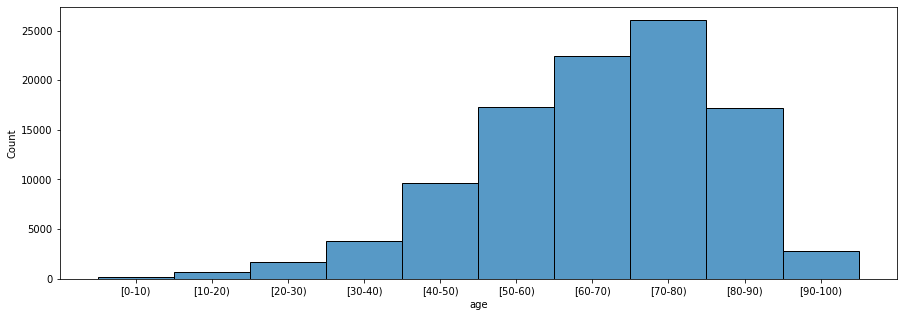

In [15]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(dfdiabetes.age, ax=ax)

the histogram above clearly depicts that the number of patients bellow 20  or above 90 years are the lowest in proportion in comparison to the interval 20 to 90.

It is important to notice the purpose of the model, that it will be used to decide if the patient will be readmitted in the hospital or not over a period of time.

<AxesSubplot:xlabel='age', ylabel='Count'>

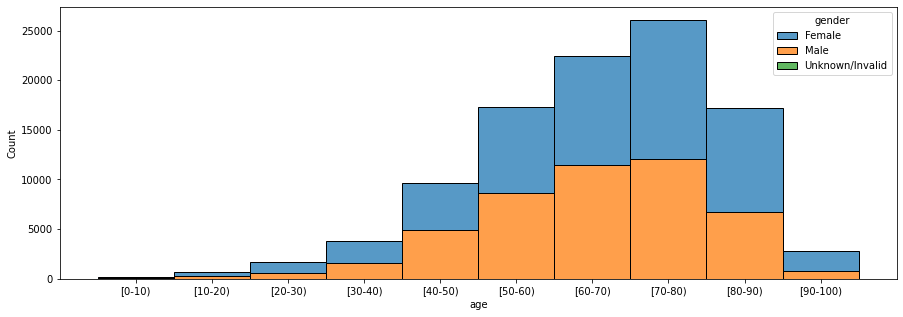

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=dfdiabetes, x="age", hue="gender", multiple="stack", ax = ax)

The proportions of male/female along the age intervals are distributed equally.

In [17]:
dfdiabetes.race.value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [18]:
dfdiabetes.head(1)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO


### Nominal Variables

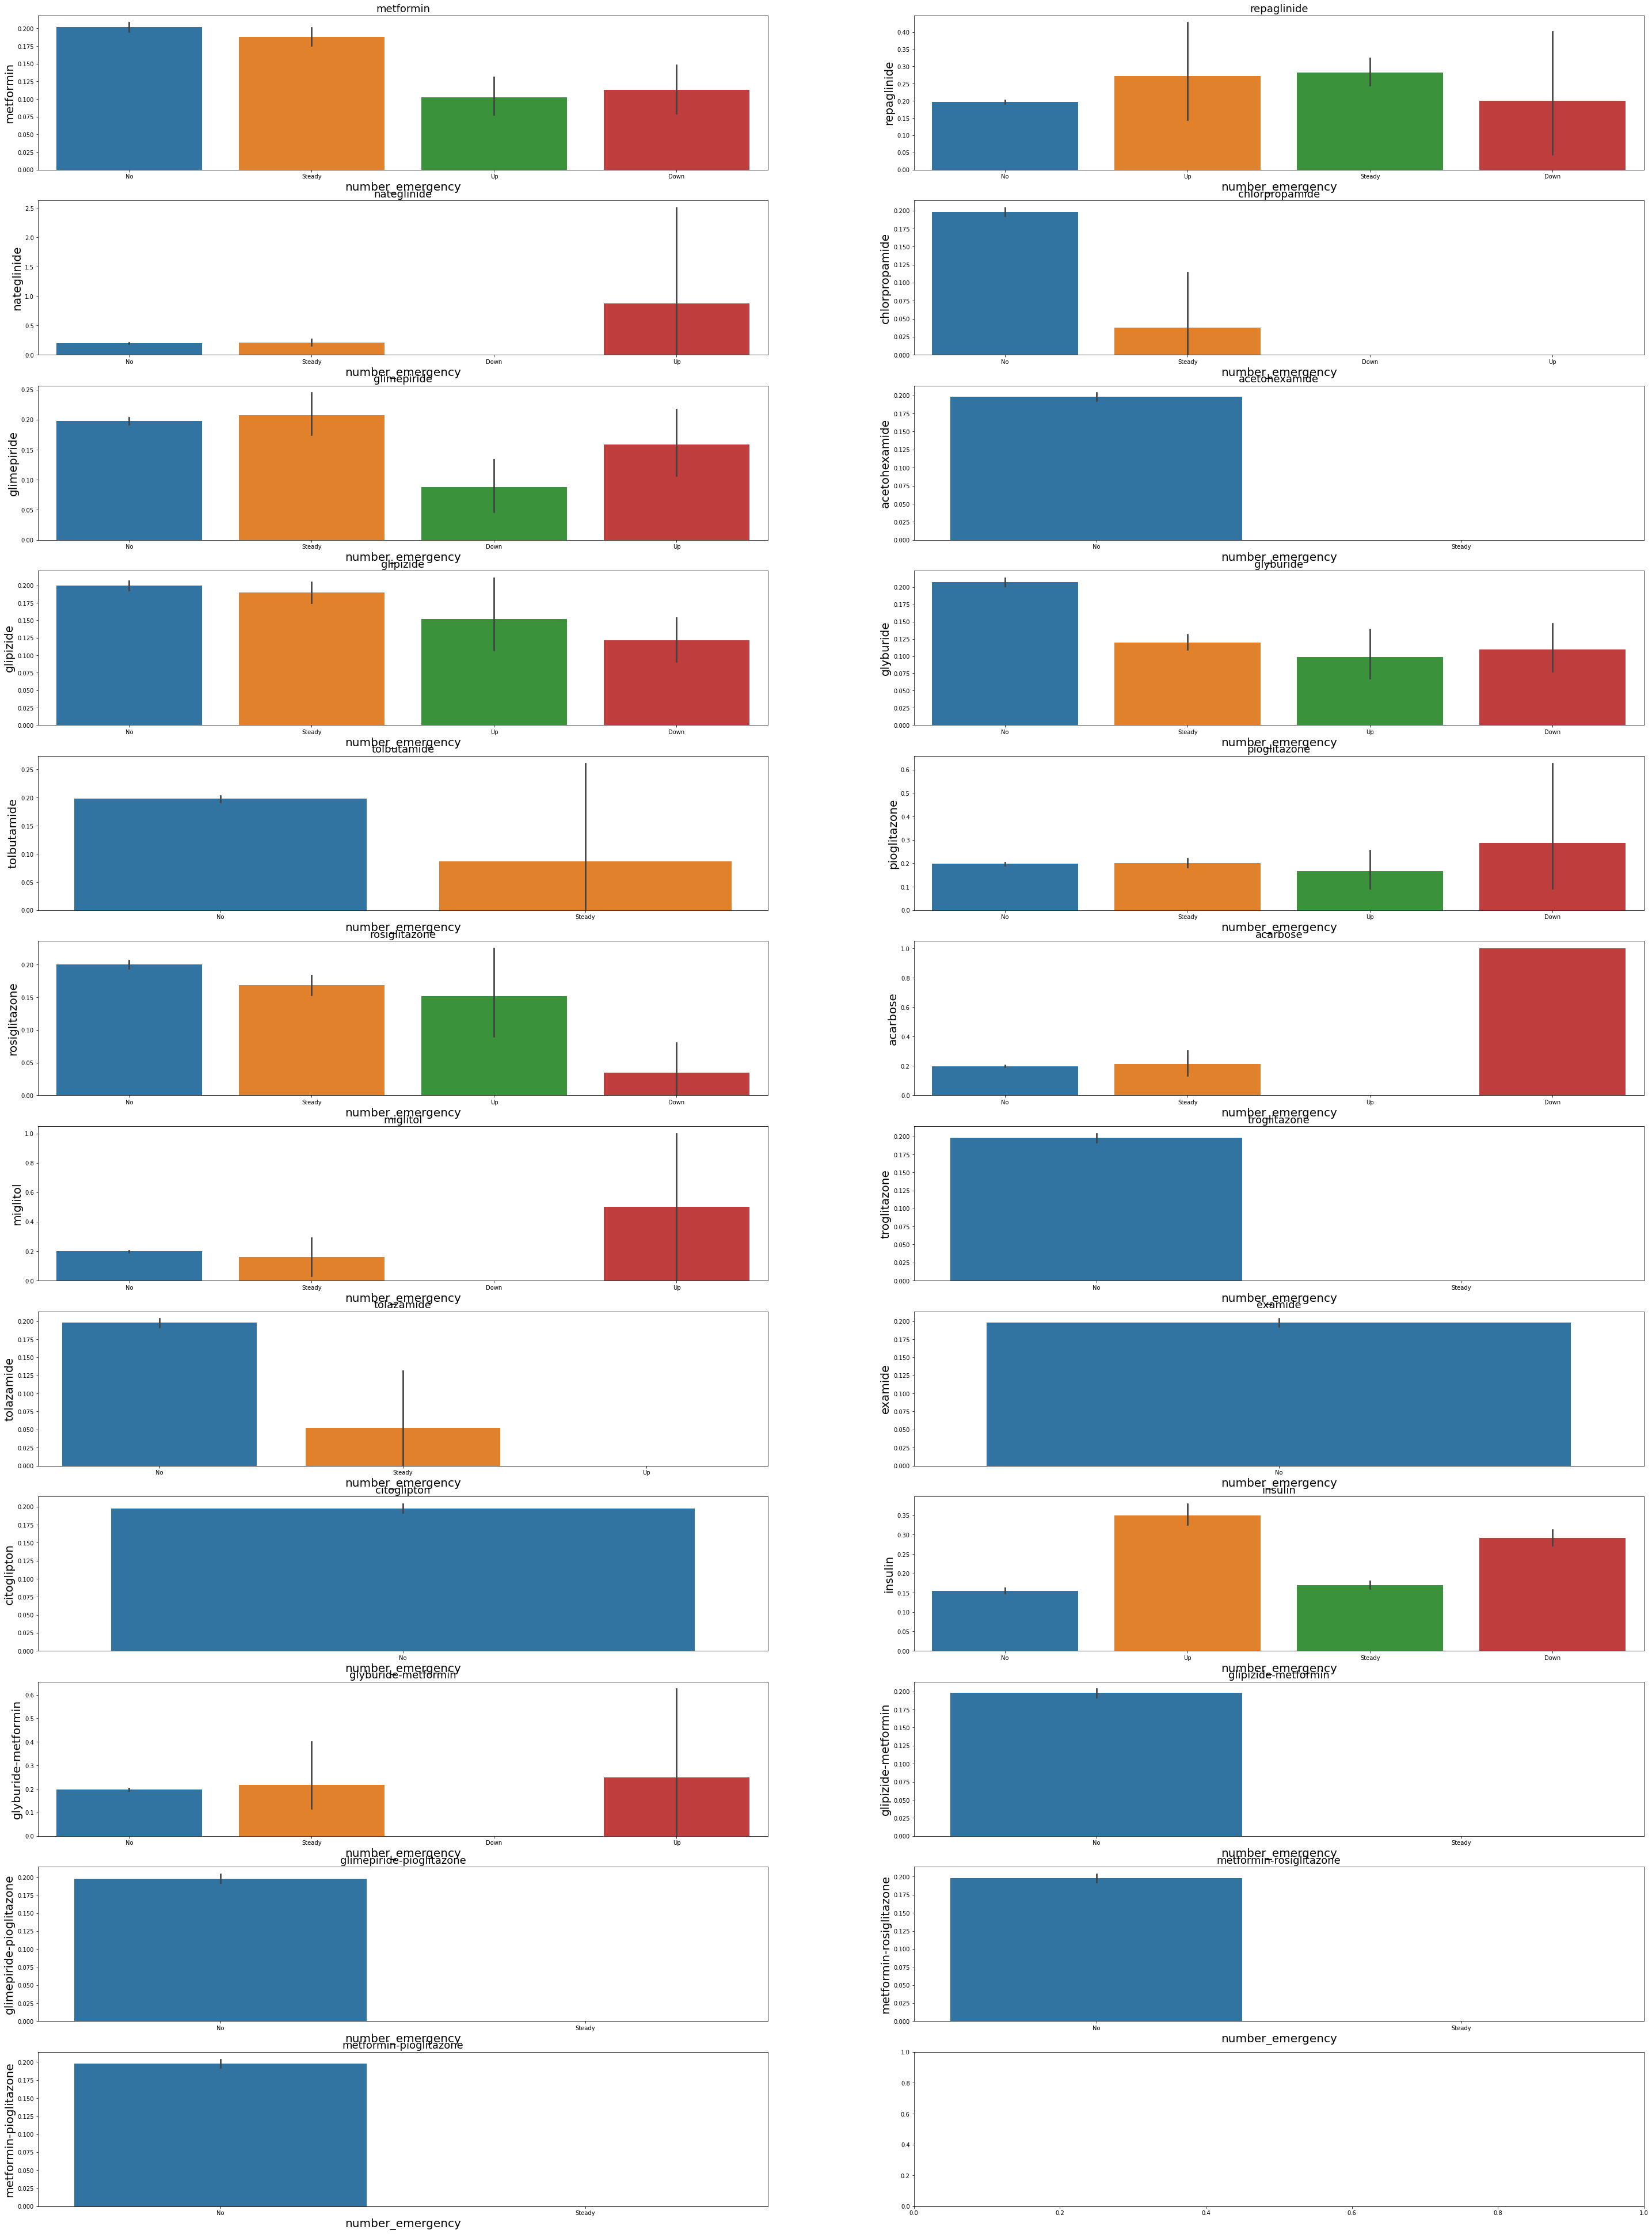

In [19]:
binary_features = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

fig, axs = plt.subplots(12, 2, figsize = (50, 70))
axs = axs.ravel()

for i in range(0, len(binary_features)):
    axs[i].set_title(binary_features[i],fontsize=18)
    
    sns.barplot(dfdiabetes[binary_features[i]], dfdiabetes["number_emergency"], ax = axs[i])
    axs[i].set_xlabel('number_emergency', fontsize = 20)
    axs[i].set_ylabel(binary_features[i], fontsize = 20)

#### Continuous and Discrete variables

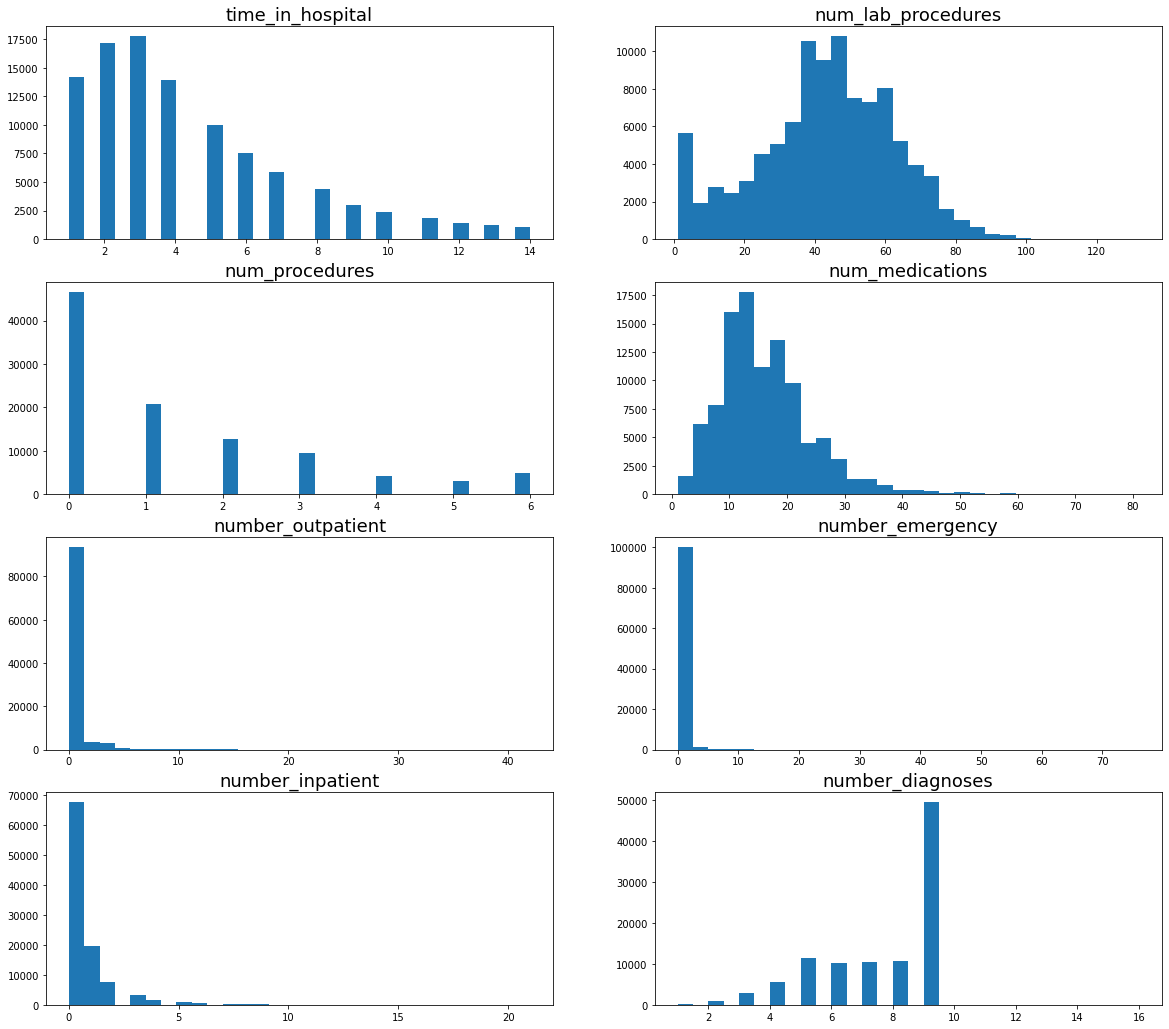

In [20]:
numeric_cols = ['time_in_hospital','num_lab_procedures', 
                'num_procedures', 'num_medications', 'number_outpatient', 
                'number_emergency', 'number_inpatient', 'number_diagnoses']

fig, axs = plt.subplots(4, 2, figsize = (20, 18))
axs = axs.ravel()

for i in range(0, len(numeric_cols)):
    axs[i].set_title(numeric_cols[i],fontsize=18)
    axs[i].hist(dfdiabetes[numeric_cols[i]], bins = 30)

For  ``time_in_hospital`` , ``number_medications``, ``num_lab_procedures`` are **right skewed**, 
which can be due to the presence of outliers, however all these instances have to be analyzed. We can apply a transformations in order to smooth these values and get a Gaussian Distribution shape.

Most people have been been medicated from 10 to 20 medications in their encounter. And there is an encounter where the patient received more than 80 medications, the medical specialty is Surgery-Cardiovascular/Thoracic.

In [81]:
dfdiabetes["num_medications_log"] = np.log1p(dfdiabetes["num_medications"])
dfdiabetes["time_in_hospital_log"] = np.log(dfdiabetes["time_in_hospital"])
dfdiabetes["num_lab_procedures_log"] = np.log1p(dfdiabetes["num_lab_procedures"])

<AxesSubplot:xlabel='num_medications_log', ylabel='Count'>

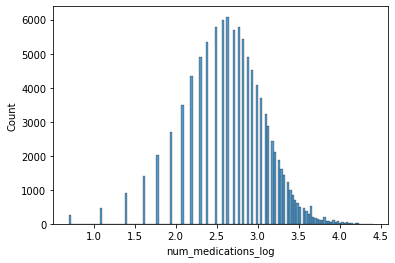

In [85]:
sns.histplot(dfdiabetes["num_medications_log"])

<AxesSubplot:xlabel='num_lab_procedures_log', ylabel='Count'>

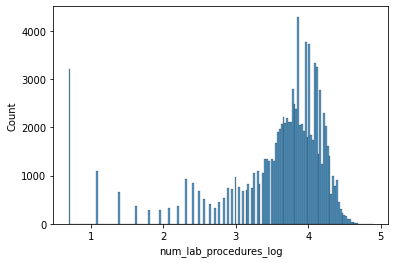

In [82]:
sns.histplot(dfdiabetes["num_lab_procedures_log"])

---

In [21]:
dfdiabetes.patient_nbr.nunique()

71518

In [22]:
percentage_0_visit = dfdiabetes[dfdiabetes.number_inpatient==0].patient_nbr.nunique()/dfdiabetes.patient_nbr.nunique()*100
print("{:0.2f}%".format(percentage_0_visit), "of the patient have not had a preceding encounter the year before." )

89.16% of the patient have not had a preceding encounter the year before.


In [23]:
percentage_0_visit = dfdiabetes[dfdiabetes.number_inpatient>1].patient_nbr.nunique()/dfdiabetes.patient_nbr.nunique()*100
print("{:0.2f}%".format(percentage_0_visit), "of the patient have not had a preceding encounter the year before.")

11.45% of the patient have not had a preceding encounter the year before.


In [24]:
dfdiabetes[dfdiabetes.number_inpatient>3].readmitted.value_counts(normalize = True)*100

>30    48.653106
<30    30.703683
NO     20.643211
Name: readmitted, dtype: float64

In [25]:
dfdiabetes[dfdiabetes.number_inpatient>2].shape

(7049, 50)

In [26]:
dfdiabetes[dfdiabetes.number_inpatient>2].readmitted.value_counts(normalize = True)*100

>30    49.028231
<30    25.663215
NO     25.308554
Name: readmitted, dtype: float64

what are the characteristics for a patient whose number of medications is greater than 80 in an encounter?

In [27]:
dfdiabetes[dfdiabetes.num_medications>80]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
43877,135412542,24189597,Caucasian,Male,[60-70),NaN,3,22,1,10,MC,Surgery-Cardiovascular/Thoracic,57,3,81,0,0,0,414,411,496,6,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30


In [28]:
dfdiabetes.diabetesMed.value_counts()

Yes    78363
No     23403
Name: diabetesMed, dtype: int64

### Correlations and Variance

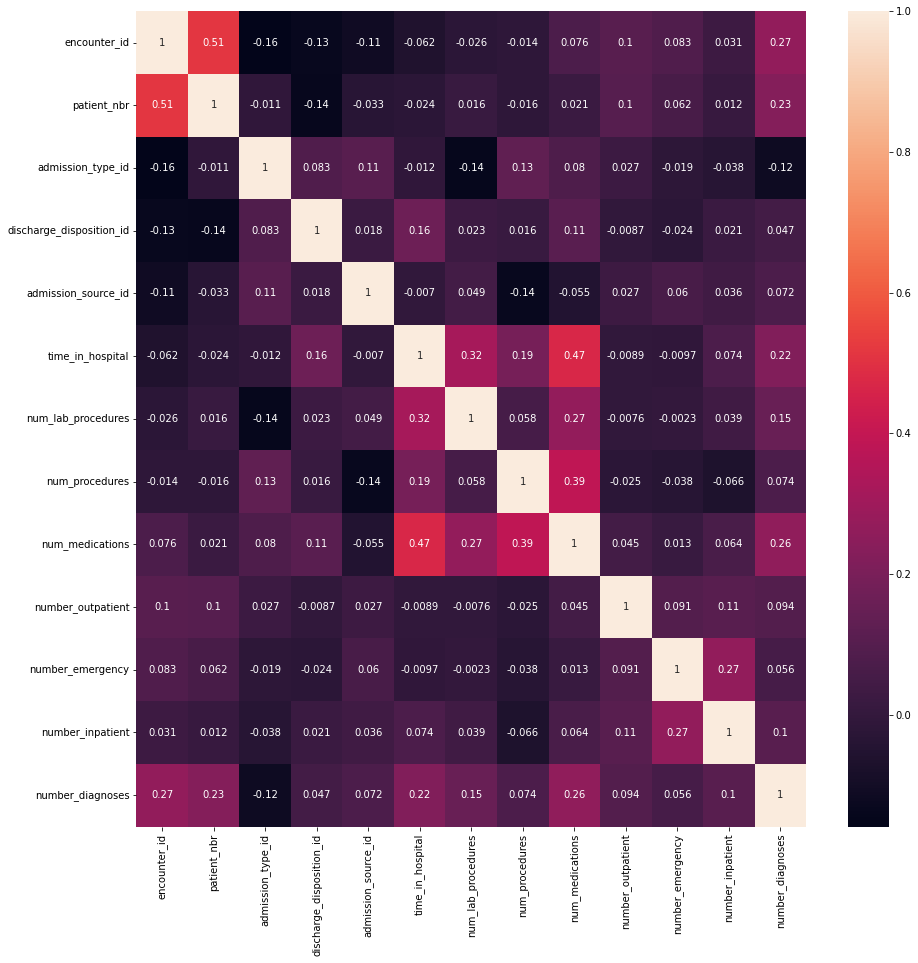

In [29]:
dfcorr = dfdiabetes.select_dtypes(exclude = "object").corr(method ='pearson')
plt.figure(figsize=(15, 15))
sns.heatmap(dfcorr, annot = True)
plt.show()

It is observed that **time in hospital** and **num_medications** have a pearson correlation of 0.47.

The coefficient of determination:
   - **time in hospital** and **num_medications** shared about 22.1% of their variance.  

#### Integrate category details

In [30]:
def preprocess_idmap(dfidmap):
    """
    :param dfidmap: Dataframe with categories detail (IDs_mapping).
    """
    dfidmap["is_str"] = dfidmap[0].apply(lambda x: 1 if  len(str(x))>4 else 0 )
    list_df_detail = {}

    indexes_df = dfidmap[dfidmap.is_str==1].index.values
    init = 0

    for i in range(1, len(indexes_df)+1):
        if i != len(indexes_df):
            tmp = dfidmap.iloc[indexes_df[i-1]: indexes_df[i], :]
        else:
            tmp = dfidmap.iloc[indexes_df[i-1]:, :] 
        name_col = tmp.iloc[0,0]   
        list_df_detail[name_col] = tmp
    return list_df_detail

In [31]:
def  process_dict_idmap(df):
    """
    :param df: DataFrame with id definitions
    :type df: pd.DataFrame()
    """
    df = df.reset_index()
    df.columns = df.iloc[0, :].values
    df = df.iloc[1:,:]
    df = df.set_index(df.columns[1])
    del df[df.columns[0]]
    del df[1]
    return df.to_dict(orient = "dict")

In [32]:
def get_description_ids(dict_df, dfbase, list_features):
    for i in list_features:
        dict_map_values = process_dict_idmap(dict_df[i])["description"]
        dfbase[i] = dfbase[i].astype(str)
        dfbase[f"{i}_encoded"] = dfbase[i].map(dict_map_values)   
    return dfbase

In [33]:
dict_df = preprocess_idmap(dfidmap)

In [34]:
list_ids = ["admission_type_id", "discharge_disposition_id", "admission_source_id"]
dfdiabetes = get_description_ids(dict_df, dfdiabetes, list_ids)
dfdiabetes

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_id_encoded,discharge_disposition_id_encoded,admission_source_id_encoded
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,NaN,Not Mapped,Physician Referral
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,MC,NaN,51,0,16,0,0,0,250.13,291,458,9,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,Emergency,Discharged/transferred to SNF,Emergency Room
101762,443847782,74694222,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,MC,NaN,33,3,18,0,0,1,560,276,787,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO,Emergency,Discharged/transferred to ICF,Transfer from a Skilled Nursing Facility (SNF)
101763,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,53,0,9,1,0,0,38,590,296,13,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room
101764,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,45,2,21,0,0,1,996,285,998,9,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Urgent,Discharged/transferred to SNF,Emergency Room


### Readmission

In this analysis the readmission variable will be use as our target, which indicates the readmission of a patient within the first 30 days.

- If the patient was readmitted in less than 30 days **<30**
- If the patient was readmitted in more than 30 days **>30**
- If the patient was not readmitted after leaving the encounter **NO**

In [35]:
dfdiabetes.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [36]:
%%time
target_dict = { 'NO':0,
                '>30':0,
                '<30':1}

dfdiabetes["readmitted_encoded"] = dfdiabetes.readmitted.map(target_dict)

Wall time: 7 ms


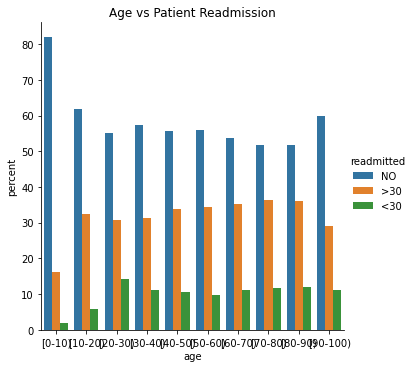

In [37]:
df1 = dfdiabetes.groupby("age")["readmitted"].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent').reset_index()
sns.catplot(data = df1, x = "age", y = 'percent', kind='bar', hue = "readmitted")
plt.title("Age vs Patient Readmission");

There is less proportion of readmission <30 cases for younger people between 10 - 20 years. Whereas in the other intervals the percentages are quite similar between 10 - 15%.

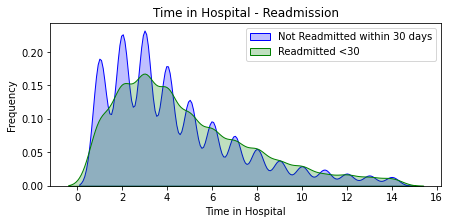

In [38]:
fig = plt.figure(figsize=(7, 3))

ax = sns.kdeplot(dfdiabetes.loc[(dfdiabetes.readmitted_encoded == 0), "time_in_hospital"],
                 color = "b", shade = True, label = "Not Readmitted within 30 days")

ax = sns.kdeplot(dfdiabetes.loc[(dfdiabetes.readmitted_encoded == 1), "time_in_hospital"],
                 color = "g", shade = True, label = "Readmitted <30")
ax.legend(loc="upper right")

ax.set_xlabel("Time in Hospital")
ax.set_ylabel("Frequency")
ax.set_title("Time in Hospital - Readmission")
plt.show()

<AxesSubplot:xlabel='readmitted', ylabel='num_medications'>

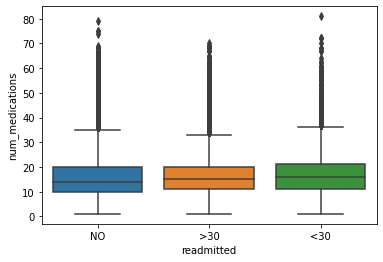

In [39]:
sns.boxplot(data = dfdiabetes, x = "readmitted", y = "num_medications")

<AxesSubplot:xlabel='number_emergency', ylabel='num_medications'>

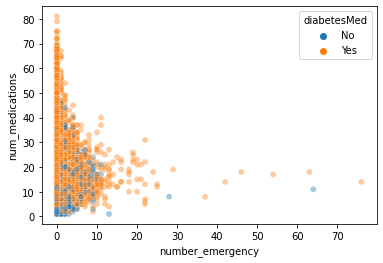

In [40]:
sns.scatterplot(data = dfdiabetes, x="number_emergency", 
            y="num_medications", hue = "diabetesMed", alpha = 0.4)

<AxesSubplot:xlabel='number_emergency', ylabel='num_medications'>

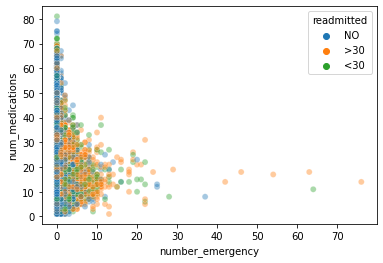

In [41]:
sns.scatterplot(data = dfdiabetes, x="number_emergency", 
            y="num_medications", hue = "readmitted", alpha = 0.4)

- How powerful is the variable ``diabetesMed`` to predict if a patient will return the first 30 days.

For more information about phi-coefficient https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

In [42]:
from  sklearn.preprocessing import LabelEncoder
encoder_label = LabelEncoder()

dfdiabetes["diabetesmed_encoded"] = encoder_label.fit_transform(dfdiabetes["diabetesMed"])

In [43]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(dfdiabetes.readmitted_encoded, dfdiabetes.diabetesmed_encoded)

0.02712465190622339

#### Binary variables vs Readmission
Let's make the medications variables binary, in order to measure how contribute to predict the target.

In [44]:
def encoded_ordinal_med(df,  list_feat, dict_val, sufix = "_encoded")-> pd.DataFrame:
    results_list = []
    
    for col in list_feat:
        df[f"{col}{sufix}"] = df[col].map(dict_val)
    return df

In [45]:
dict_binary = {'No':0, 
                'Up':1, 
                'Steady':1, 
                'Down':1}

binary_features = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

In [46]:
dfdiabetes = encoded_ordinal_med(dfdiabetes, binary_features, dict_binary)

In [318]:
results_list = []

negative_contribution = []
positive_contribution = []
for col in binary_features:
    result = matthews_corrcoef(dfdiabetes.readmitted_encoded, dfdiabetes[f"{col}_encoded"])
    results_list.append(results_list)
    
    if result<0:
        negative_contribution.append(col)
    else:
        positive_contribution.append(col)
    print("Readmitted_encoded -  {}_encoded".format(col), "phi-coefficient: {0:.4f}".format(result) )

Readmitted_encoded -  metformin_encoded phi-coefficient: -0.0229
Readmitted_encoded -  repaglinide_encoded phi-coefficient: 0.0085
Readmitted_encoded -  nateglinide_encoded phi-coefficient: 0.0006
Readmitted_encoded -  chlorpropamide_encoded phi-coefficient: -0.0049
Readmitted_encoded -  glimepiride_encoded phi-coefficient: -0.0070
Readmitted_encoded -  acetohexamide_encoded phi-coefficient: -0.0011
Readmitted_encoded -  glipizide_encoded phi-coefficient: 0.0034
Readmitted_encoded -  glyburide_encoded phi-coefficient: -0.0058
Readmitted_encoded -  tolbutamide_encoded phi-coefficient: -0.0033
Readmitted_encoded -  pioglitazone_encoded phi-coefficient: -0.0053
Readmitted_encoded -  rosiglitazone_encoded phi-coefficient: -0.0058
Readmitted_encoded -  acarbose_encoded phi-coefficient: -0.0036
Readmitted_encoded -  miglitol_encoded phi-coefficient: -0.0004
Readmitted_encoded -  troglitazone_encoded phi-coefficient: -0.0019
Readmitted_encoded -  tolazamide_encoded phi-coefficient: -0.0022
Re

In [319]:
positive_contribution

['repaglinide',
 'nateglinide',
 'glipizide',
 'examide',
 'citoglipton',
 'insulin']

In [320]:
negative_contribution

['metformin',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone']

The correlations are weak, but positive. It means, that there is a slightly increment in the probability of returning within the first 30 days if the patient have been diagnosed with diabetes or if have been medicated with insulin.

There can be a wide range of combinations between all the interactions in the variables which we can compare with our target, in order to get useful features.

These result depending on the medication it reduces or stimulates the  production of insulin.

For example ``metformin-rosiglitazone`` is used to treat a type of diabetes called type 2 diabetes. It is used together with a proper diet and exercise to help control blood sugar levels. It makes sense that if the patient have received treatment with this medication is less likely that he will be readmitted within the first 30 days.

---

## Data Preparation

### Encoding outcome

In [44]:
dfdiabetes.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [45]:
dfdiabetes["readmitted_encoded"].value_counts(normalize = True)*100

0    88.840084
1    11.159916
Name: readmitted_encoded, dtype: float64

### Feature Engineering

#### admission type

In [260]:
## This values were selected arbitrarily, It would be useful to understand the context of each admission. 
# Why some these types are not mapped or wht are the criterias between Urgent and a Emergency.
admission_ordinal_dict = {'nan':0, 
'Emergency':6, 
'Urgent':5, 
'Elective':1, 
'Newborn':4, 
'Not Available':0,
'Not Mapped':0, 
'Trauma Center':2}

In [261]:
 dfdiabetes["admission_type_id_encoded"] =  dfdiabetes["admission_type_id_encoded"].astype(str)
dfdiabetes["admission_type_id_ordinal"] =  dfdiabetes["admission_type_id_encoded"].map(admission_ordinal_dict)

#### transform age

In [262]:
%%time
def split_age(x):
    """
    :param x: string with interval format [a, b].
    :type x: str
    """
    list_x = x.split("-")
    left_age = list_x[0][1:]
    right_age = list_x[1][:-1]
    return pd.Series([left_age, right_age])

dfdiabetes.loc[:, ["left_age", "right_age"]] = list(map(split_age, dfdiabetes.loc[:, "age"].values))

Wall time: 10.9 s


In [263]:
dfdiabetes["left_age"] = dfdiabetes["left_age"].astype(int)
dfdiabetes["right_age"] = dfdiabetes["right_age"].astype(int)

In [264]:
dfdiabetes["mean_age"] = dfdiabetes.loc[:, ["left_age", "right_age"]].mean(axis = 1)

In [265]:
dfdiabetes["mean_age_log"] = np.log1p(dfdiabetes["mean_age"])

#### encoding ordinal variables

In [266]:
dict_ordinal = {'No':0, 
                'Up':3, 
                'Steady':2, 
                'Down':1}

ordinal_features = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

dfdiabetes = encoded_ordinal_med(dfdiabetes, ordinal_features, dict_ordinal, "_encoded_ordinal")

#### Medications

In [329]:
negative_contribution_enoded = ["{}_encoded_ordinal".format(j) for j in negative_contribution]
positive_contribution_enoded = ["{}_encoded_ordinal".format(j) for j in positive_contribution]

In [330]:
dfdiabetes["negative_contribute_medications"] = dfdiabetes[negative_contribution_enoded].sum(axis = 1)
dfdiabetes["positive_contribute_medications"] = dfdiabetes[positive_contribution_enoded].sum(axis = 1)

In [331]:
dfdiabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_id_encoded,discharge_disposition_id_encoded,admission_source_id_encoded,readmitted_encoded,diabetesmed_encoded,metformin_encoded,repaglinide_encoded,nateglinide_encoded,chlorpropamide_encoded,glimepiride_encoded,acetohexamide_encoded,glipizide_encoded,glyburide_encoded,tolbutamide_encoded,pioglitazone_encoded,rosiglitazone_encoded,acarbose_encoded,miglitol_encoded,troglitazone_encoded,tolazamide_encoded,examide_encoded,citoglipton_encoded,insulin_encoded,glyburide-metformin_encoded,glipizide-metformin_encoded,glimepiride-pioglitazone_encoded,metformin-rosiglitazone_encoded,metformin-pioglitazone_encoded,admission_type_id_ordinal,left_age,right_age,mean_age,metformin_encoded_ordinal,repaglinide_encoded_ordinal,nateglinide_encoded_ordinal,chlorpropamide_encoded_ordinal,glimepiride_encoded_ordinal,acetohexamide_encoded_ordinal,glipizide_encoded_ordinal,glyburide_encoded_ordinal,tolbutamide_encoded_ordinal,pioglitazone_encoded_ordinal,rosiglitazone_encoded_ordinal,acarbose_encoded_ordinal,miglitol_encoded_ordinal,troglitazone_encoded_ordinal,tolazamide_encoded_ordinal,examide_encoded_ordinal,citoglipton_encoded_ordinal,insulin_encoded_ordinal,glyburide-metformin_encoded_ordinal,glipizide-metformin_encoded_ordinal,glimepiride-pioglitazone_encoded_ordinal,metformin-rosiglitazone_encoded_ordinal,metformin-pioglitazone_encoded_ordinal,num_medications_log,time_in_hospital_log,num_lab_procedures_log,mean_age_log,negative_contribute_medications,positive_contribute_medications
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,nan,Not Mapped,Physician Referral,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.693147,0.000000,3.737670,1.791759,0,0
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,10,20,15.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2.944439,1.098612,4.094345,2.772589,0,3
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,20,30,25.0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.639057,0.693147,2.484907,3.258097,0,2
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,30,40,35.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2.833213,0.693147,3.806662,3.583519,0,3
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,40,50,45.0,0,0,0,0,0,0,2,0,0,0,0,

In [267]:
# list(dfdiabetes.columns)

#### trnasforming skewed features

In [332]:
dfdiabetes["num_medications_log"] = np.log1p(dfdiabetes["num_medications"])
dfdiabetes["time_in_hospital_log"] = np.log(dfdiabetes["time_in_hospital"])
dfdiabetes["num_lab_procedures_log"] = np.log1p(dfdiabetes["num_lab_procedures"])

In [333]:
dfdiabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admission_type_id_encoded,discharge_disposition_id_encoded,admission_source_id_encoded,readmitted_encoded,diabetesmed_encoded,metformin_encoded,repaglinide_encoded,nateglinide_encoded,chlorpropamide_encoded,glimepiride_encoded,acetohexamide_encoded,glipizide_encoded,glyburide_encoded,tolbutamide_encoded,pioglitazone_encoded,rosiglitazone_encoded,acarbose_encoded,miglitol_encoded,troglitazone_encoded,tolazamide_encoded,examide_encoded,citoglipton_encoded,insulin_encoded,glyburide-metformin_encoded,glipizide-metformin_encoded,glimepiride-pioglitazone_encoded,metformin-rosiglitazone_encoded,metformin-pioglitazone_encoded,admission_type_id_ordinal,left_age,right_age,mean_age,metformin_encoded_ordinal,repaglinide_encoded_ordinal,nateglinide_encoded_ordinal,chlorpropamide_encoded_ordinal,glimepiride_encoded_ordinal,acetohexamide_encoded_ordinal,glipizide_encoded_ordinal,glyburide_encoded_ordinal,tolbutamide_encoded_ordinal,pioglitazone_encoded_ordinal,rosiglitazone_encoded_ordinal,acarbose_encoded_ordinal,miglitol_encoded_ordinal,troglitazone_encoded_ordinal,tolazamide_encoded_ordinal,examide_encoded_ordinal,citoglipton_encoded_ordinal,insulin_encoded_ordinal,glyburide-metformin_encoded_ordinal,glipizide-metformin_encoded_ordinal,glimepiride-pioglitazone_encoded_ordinal,metformin-rosiglitazone_encoded_ordinal,metformin-pioglitazone_encoded_ordinal,num_medications_log,time_in_hospital_log,num_lab_procedures_log,mean_age_log,negative_contribute_medications,positive_contribute_medications
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,nan,Not Mapped,Physician Referral,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.693147,0.000000,3.737670,1.791759,0,0
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,Emergency,Discharged to home,Emergency Room,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,10,20,15.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2.944439,1.098612,4.094345,2.772589,0,3
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,Emergency,Discharged to home,Emergency Room,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,20,30,25.0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.639057,0.693147,2.484907,3.258097,0,2
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,30,40,35.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2.833213,0.693147,3.806662,3.583519,0,3
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,40,50,45.0,0,0,0,0,0,0,2,0,0,0,0,

#### Aggregate data

To prevent data leakage only the first encounter for each patient will be selected as a instance for training and validation.
- There are other options like sampling an encounter of each patient not taking into account the order.

In [397]:
dfaggr = dfdiabetes.groupby("patient_nbr").agg({'encounter_id':'first',
                                                
                                                'num_lab_procedures':'first','num_procedures':'first',
                                                'num_medications':'first','number_outpatient':'first',
                                                'number_emergency':'first','number_inpatient':'first',
                                                 'mean_age':'first','mean_age_log':'first',  
                                                'repaglinide_encoded_ordinal':'first',
                                                 'nateglinide_encoded_ordinal':'first',
                                                 'chlorpropamide_encoded_ordinal':'first',
                                                 'glimepiride_encoded_ordinal':'first',
                                                 'acetohexamide_encoded_ordinal':'first',
                                                 'glipizide_encoded_ordinal':'first',
                                                 'glyburide_encoded_ordinal':'first',
                                                 'tolbutamide_encoded_ordinal':'first',
                                                 'pioglitazone_encoded_ordinal':'first',
                                                 'rosiglitazone_encoded_ordinal':'first',
                                                 'acarbose_encoded_ordinal':'first',
                                                 'miglitol_encoded_ordinal':'first',
                                                 'troglitazone_encoded_ordinal':'first',
                                                 'tolazamide_encoded_ordinal':'first',
                                                 'examide_encoded_ordinal':'first',
                                                 'citoglipton_encoded_ordinal':'first',
                                                 'insulin_encoded_ordinal':'first',
                                                 'glyburide-metformin_encoded_ordinal':'first',
                                                 'glipizide-metformin_encoded_ordinal':'first',
                                                 'glimepiride-pioglitazone_encoded_ordinal':'first',
                                                 'metformin-rosiglitazone_encoded_ordinal':'first',
                                                 'metformin-pioglitazone_encoded_ordinal':'first',
                                                'admission_type_id_ordinal':'first',
                                                'num_medications_log':'first',
                                                'time_in_hospital_log':'first',
                                                'num_lab_procedures_log':'first',
                                                'negative_contribute_medications':'first',
                                                'positive_contribute_medications':'first',
                                                'race':'first',
                                                'gender':'first',
                                                'readmitted_encoded':'first'
                                      }).reset_index()

In [398]:
dfaggr.to_csv("../data/processed/datatrain.csv", index = False)

## Build Model

In [389]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


from sklearn.metrics import  classification_report
from sklearn.metrics import  ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [337]:
dfaggr.patient_nbr.nunique()

71518

In [338]:
dfaggr.readmitted_encoded.value_counts(normalize = True)*100

0    91.200817
1     8.799183
Name: readmitted_encoded, dtype: float64

In [339]:
dfaggr.shape

(71518, 39)

In [340]:
target = 'readmitted_encoded'

### Train Test Split

In [341]:
X, y = dfaggr.loc[:, :], dfaggr.loc[:, target]

In [342]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

In [343]:
X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=0, stratify=y_train)

#### Balance classes in X_train

In [344]:
X_train_class0 = X_train_2[X_train_2.readmitted_encoded == 0]
X_train_class1 = X_train_2[X_train_2.readmitted_encoded == 1]
X_train_class0_balanced = X_train_class0.sample(int(X_train_class1.shape[0]*1.20))

In [345]:
X_train_2 = pd.concat([X_train_class0_balanced, X_train_class1])
y_train_2 = X_train_2.loc[:, target]

In [346]:
train_val_count = y_train_2.value_counts(normalize = True).to_frame()
train_val_count["set"] = 'train'

In [347]:
valid_val_count = y_valid.value_counts(normalize = True).to_frame()
valid_val_count["set"] = 'valid'

In [348]:
test_val_count =y_test.value_counts(normalize = True).to_frame()
test_val_count["set"] = 'test'

In [349]:
pd.concat([train_val_count, valid_val_count, test_val_count], axis =0)

,readmitted_encoded,set
0,0.545434,train
1,0.454566,train
0,0.911999,valid
1,0.088001,valid
0,0.911983,test
1,0.088017,test


### Training

In [350]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [351]:
features = list(dfaggr.columns[:-1])

In [352]:
features.pop(0)

'patient_nbr'

In [289]:
features.pop(0)

'encounter_id'

In [354]:
features = ['num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient',
 'mean_age', 'repaglinide_encoded_ordinal',
 'nateglinide_encoded_ordinal', 'chlorpropamide_encoded_ordinal',
 'glimepiride_encoded_ordinal', 'acetohexamide_encoded_ordinal',
 'glipizide_encoded_ordinal', 'glyburide_encoded_ordinal',
 'tolbutamide_encoded_ordinal', 'pioglitazone_encoded_ordinal',
 'rosiglitazone_encoded_ordinal', 'acarbose_encoded_ordinal',
 'miglitol_encoded_ordinal', 'troglitazone_encoded_ordinal',
 'tolazamide_encoded_ordinal', 'examide_encoded_ordinal',
 'citoglipton_encoded_ordinal', 'insulin_encoded_ordinal',
 'glyburide-metformin_encoded_ordinal', 'glipizide-metformin_encoded_ordinal',
 'glimepiride-pioglitazone_encoded_ordinal', 'metformin-rosiglitazone_encoded_ordinal',
 'metformin-pioglitazone_encoded_ordinal', 'admission_type_id_ordinal',  
 'negative_contribute_medications', 'positive_contribute_medications']

import yaml
print(yaml.dump(features, explicit_start=True, default_flow_style=False))

---
- num_lab_procedures
- num_procedures
- num_medications
- number_outpatient
- number_emergency
- number_inpatient
- mean_age
- repaglinide_encoded_ordinal
- nateglinide_encoded_ordinal
- chlorpropamide_encoded_ordinal
- glimepiride_encoded_ordinal
- acetohexamide_encoded_ordinal
- glipizide_encoded_ordinal
- glyburide_encoded_ordinal
- tolbutamide_encoded_ordinal
- pioglitazone_encoded_ordinal
- rosiglitazone_encoded_ordinal
- acarbose_encoded_ordinal
- miglitol_encoded_ordinal
- troglitazone_encoded_ordinal
- tolazamide_encoded_ordinal
- examide_encoded_ordinal
- citoglipton_encoded_ordinal
- insulin_encoded_ordinal
- glyburide-metformin_encoded_ordinal
- glipizide-metformin_encoded_ordinal
- glimepiride-pioglitazone_encoded_ordinal
- metformin-rosiglitazone_encoded_ordinal
- metformin-pioglitazone_encoded_ordinal
- admission_type_id_ordinal
- negative_contribute_medications
- positive_contribute_medications



In [381]:
model_xgb = xgb.XGBClassifier(n_estimators = 700, 
                             max_depth = 5,  
                             learning_rate = 0.01,
                             booster ='gbtree',
                             reg_lambda = 1,
                             objective = "binary:logistic")

In [382]:
model_xgb.fit(X_train_2[features], y_train_2, 
              eval_set=[(X_train_2[features], y_train_2),
                        (X_valid[features], y_valid)],
              early_stopping_rounds = 3)

[14:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.69267	validation_1-logloss:0.69212
[1]	validation_0-logloss:0.69220	validation_1-logloss:0.69112
[2]	validation_0-logloss:0.69175	validation_1-logloss:0.69012
[3]	validation_0-logloss:0.69130	validation_1-logloss:0.68914
[4]	validation_0-logloss:0.69086	validation_1-logloss:0.68817
[5]	validation_0-logloss:0.69043	validation_1-logloss:0.68722
[6]	validation_0-logloss:0.69000	validation_1-logloss:0.68628
[7]	validation_0-logloss:0.68959	validation_1-logloss:0.68536
[8]	validation_0-logloss:0.68919	validation_1-logloss:0.68444
[9]	validation_0-logloss:0.68879	validation_1-logloss:0.68354
[10]	validation_0-logloss:0.68841	validation_1-logloss:0.68265
[11]	va

[125]	validation_0-logloss:0.66546	validation_1-logloss:0.62879
[126]	validation_0-logloss:0.66538	validation_1-logloss:0.62857
[127]	validation_0-logloss:0.66525	validation_1-logloss:0.62836
[128]	validation_0-logloss:0.66513	validation_1-logloss:0.62816
[129]	validation_0-logloss:0.66500	validation_1-logloss:0.62794
[130]	validation_0-logloss:0.66490	validation_1-logloss:0.62773
[131]	validation_0-logloss:0.66476	validation_1-logloss:0.62753
[132]	validation_0-logloss:0.66464	validation_1-logloss:0.62734
[133]	validation_0-logloss:0.66452	validation_1-logloss:0.62713
[134]	validation_0-logloss:0.66440	validation_1-logloss:0.62693
[135]	validation_0-logloss:0.66427	validation_1-logloss:0.62673
[136]	validation_0-logloss:0.66417	validation_1-logloss:0.62654
[137]	validation_0-logloss:0.66403	validation_1-logloss:0.62637
[138]	validation_0-logloss:0.66390	validation_1-logloss:0.62618
[139]	validation_0-logloss:0.66379	validation_1-logloss:0.62600
[140]	validation_0-logloss:0.66368	valid

[254]	validation_0-logloss:0.65513	validation_1-logloss:0.61333
[255]	validation_0-logloss:0.65510	validation_1-logloss:0.61328
[256]	validation_0-logloss:0.65500	validation_1-logloss:0.61324
[257]	validation_0-logloss:0.65497	validation_1-logloss:0.61318
[258]	validation_0-logloss:0.65493	validation_1-logloss:0.61313
[259]	validation_0-logloss:0.65483	validation_1-logloss:0.61308
[260]	validation_0-logloss:0.65472	validation_1-logloss:0.61304
[261]	validation_0-logloss:0.65469	validation_1-logloss:0.61300
[262]	validation_0-logloss:0.65464	validation_1-logloss:0.61296
[263]	validation_0-logloss:0.65453	validation_1-logloss:0.61293
[264]	validation_0-logloss:0.65450	validation_1-logloss:0.61287
[265]	validation_0-logloss:0.65439	validation_1-logloss:0.61284
[266]	validation_0-logloss:0.65436	validation_1-logloss:0.61279
[267]	validation_0-logloss:0.65433	validation_1-logloss:0.61274
[268]	validation_0-logloss:0.65422	validation_1-logloss:0.61271
[269]	validation_0-logloss:0.65413	valid

[383]	validation_0-logloss:0.64979	validation_1-logloss:0.60952
[384]	validation_0-logloss:0.64975	validation_1-logloss:0.60951
[385]	validation_0-logloss:0.64973	validation_1-logloss:0.60949
[386]	validation_0-logloss:0.64973	validation_1-logloss:0.60948
[387]	validation_0-logloss:0.64969	validation_1-logloss:0.60947
[388]	validation_0-logloss:0.64968	validation_1-logloss:0.60946
[389]	validation_0-logloss:0.64966	validation_1-logloss:0.60945
[390]	validation_0-logloss:0.64965	validation_1-logloss:0.60943
[391]	validation_0-logloss:0.64962	validation_1-logloss:0.60942
[392]	validation_0-logloss:0.64960	validation_1-logloss:0.60940
[393]	validation_0-logloss:0.64957	validation_1-logloss:0.60938
[394]	validation_0-logloss:0.64955	validation_1-logloss:0.60937
[395]	validation_0-logloss:0.64951	validation_1-logloss:0.60936
[396]	validation_0-logloss:0.64949	validation_1-logloss:0.60934
[397]	validation_0-logloss:0.64948	validation_1-logloss:0.60932
[398]	validation_0-logloss:0.64947	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

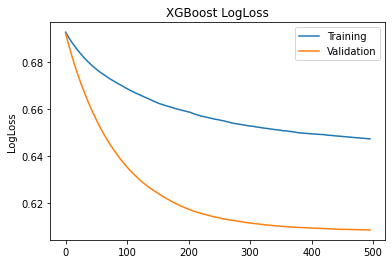

In [383]:
import matplotlib.pyplot as pyplot

results = model_xgb.evals_result()
metric = "logloss"
epochs = len(results['validation_0'][metric])
x_axis = range(0, epochs)
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0'][metric], label='Training')
ax.plot(x_axis, results['validation_1'][metric], label='Validation')
ax.legend()

pyplot.ylabel('LogLoss')
pyplot.title('XGBoost LogLoss')
pyplot.show()

In [384]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

In [385]:
pd.DataFrame({'importance':model_xgb.feature_importances_, 'features':features}).sort_values("importance", ascending = False)

,importance,features
5,0.192438,number_inpatient
16,0.057214,rosiglitazone_encoded_ordinal
23,0.055627,insulin_encoded_ordinal
2,0.054633,num_medications
6,0.054169,mean_age
13,0.051362,glyburide_encoded_ordinal
30,0.050521,negative_contribute_medications
4,0.050045,number_emergency
1,0.048049,num_procedures
29,0.047478,admission_type_id_ordinal


In [386]:
X_valid.loc[:, "prob_xgb"] = model_xgb.predict_proba(X_valid[features])[:, 1]
X_test.loc[:,"prob_xgb"] = model_xgb.predict_proba(X_test[features])[:, 1]
X_valid.loc[:, "pred_xgb"] = model_xgb.predict(X_valid[features])
X_test.loc[:,"pred_xgb"] = model_xgb.predict(X_test[features])

In [387]:
print(classification_report(X_test.loc[:,target], X_test.loc[:,"pred_xgb"]))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87     13045
           1       0.13      0.27      0.18      1259

    accuracy                           0.78     14304
   macro avg       0.53      0.55      0.53     14304
weighted avg       0.85      0.78      0.81     14304



**storage model**

In [388]:
conda_env = {
    'channels': ['conda-forge'],
    'dependencies': [
        'python=3.8.11',
        'pip'],
    'pip': [
        'mlflow',
        'xgboost ==1.4.2'
        
    ],
    'name': 'mlflow-env'
}

ml.xgboost.log_model(model_xgb, "xgb_model", conda_env=conda_env)

**Logistic regression**

In [363]:
features_log = ['mean_age_log', 'num_medications_log',
 'time_in_hospital_log', 'num_lab_procedures_log']

In [364]:
logit = LogisticRegression(fit_intercept=True, penalty='l2', C=1.0, intercept_scaling=1)
logit.fit(X_train_2[features_log], y_train_2)

LogisticRegression()

In [365]:
X_valid.loc[:, "prob_lreg"] = logit.predict_proba(X_valid[features_log])[:, 1]
X_test.loc[:,"prob_lreg"] =  logit.predict_proba(X_test[features_log])[:, 1]
X_valid.loc[:, "pred_lreg"] = logit.predict(X_valid[features_log])
X_test.loc[:,"pred_lreg"] =  logit.predict(X_test[features_log])

In [366]:
print(classification_report(X_test.loc[:, target], X_test.loc[:,"pred_lreg"]))

              precision    recall  f1-score   support

           0       0.92      0.80      0.86     13045
           1       0.11      0.26      0.16      1259

    accuracy                           0.76     14304
   macro avg       0.52      0.53      0.51     14304
weighted avg       0.85      0.76      0.80     14304



In [309]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(X_test.loc[:,"pred_lreg"], name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,10287,2758,13045
1,913,346,1259
All,11200,3104,14304


#### Random Forest

In [367]:
model_rf = RandomForestClassifier(n_estimators = 700)
model_rf.fit(X_train_2[features], y_train_2)

RandomForestClassifier(n_estimators=700)

In [372]:
pd.DataFrame({'importance':model_rf.feature_importances_, 'features':features}).sort_values("importance", ascending = False).head(10)

,importance,features
0,0.256576,num_lab_procedures
2,0.205480,num_medications
6,0.100308,mean_age
1,0.092288,num_procedures
29,0.063941,admission_type_id_ordinal
30,0.048384,negative_contribute_medications
3,0.036789,number_outpatient
31,0.034027,positive_contribute_medications
5,0.031662,number_inpatient
23,0.027885,insulin_encoded_ordinal


In [369]:
X_valid.loc[:, "prob_rf"] = model_rf.predict_proba(X_valid[features])[:, 1]
X_test.loc[:,"prob_rf"] =  model_rf.predict_proba(X_test[features])[:, 1]
X_valid.loc[:, "pred_rf"] = model_rf.predict(X_valid[features])
X_test.loc[:,"pred_rf"] =  model_rf.predict(X_test[features])

In [392]:
precision_score(X_test.loc[:, target], X_test.loc[:,"pred_rf"])*100

11.274315204446209

In [393]:
recall_score(X_test.loc[:, target], X_test.loc[:,"pred_rf"])*100

45.11517077045274

In [391]:
accuracy_score(X_test.loc[:, target], X_test.loc[:,"pred_rf"])*100

63.91918344519015

In [370]:
print(classification_report(X_test.loc[:, target], X_test.loc[:,"pred_rf"]))

              precision    recall  f1-score   support

           0       0.93      0.66      0.77     13045
           1       0.11      0.45      0.18      1259

    accuracy                           0.64     14304
   macro avg       0.52      0.55      0.47     14304
weighted avg       0.85      0.64      0.72     14304



The Accuracy metric **63.91%** will only tell us how many of the patients were correctly classified but it does not add any information about if these patients where with respect to our class of interest in this case when the patient is readmitted after and encounter.

Precision **11.27%** and recall **45%** both metrics should be balanced and both give us different point of view with respect to our label of interest.

Precision will give us information the proportion of patients the model predict they would be readmitted, regarding to the total number of patients who actually were readmitted.

Recall in contrast measure from the real number of patients who actually were readmitted against how many of them were actually predicted correctly.

The model is performing poorly in the class of interest, even the data was balanced:

What further improvements can be done:
- Create other features from medications.
- Extract features from Insurance Variables.
- It would be insightful to get access to the procedures and their codification.
- Approach another method to select the instances from the training phase.

In [371]:
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(X_test.loc[:,"pred_rf"], name = 'Predict'), margins = True)

Predict,0,1,All
Actual,,,
0,8575,4470,13045
1,691,568,1259
All,9266,5038,14304


In [376]:
conda_env = {
    'channels': ['conda-forge'],
    'dependencies': [
        'python=3.8.11',
        'pip'],
    'pip': [
        'mlflow',
        'scikit-learn==0.24.2'
        
    ],
    'name': 'mlflow-env'
}

ml.sklearn.log_model(model_rf, "rf_model", conda_env=conda_env)

## Fairness Analysis
Analyze the bias in each demographic group of interest, to prevent a bias either in favor or not.

For example: 
The model can predict high more likelihood that Females, between 80 -90 are more likely to be readmitted, and then exclude any other situation such as male between 80 - 90. But We know it would depend on the data we train on and the parity of these groups.

In [414]:
dfaggr.loc[:,"score"] =  model_rf.predict(dfaggr[features])

In [415]:
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

### Demographic Bias

In [416]:
dfaggr["label_value"] = dfaggr[target]
ae_subset_df = dfaggr[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

In [417]:
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)

f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


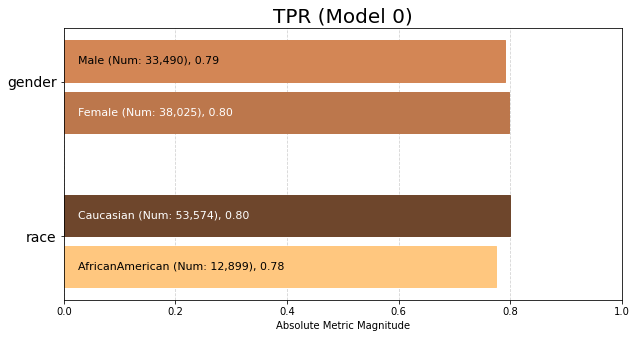

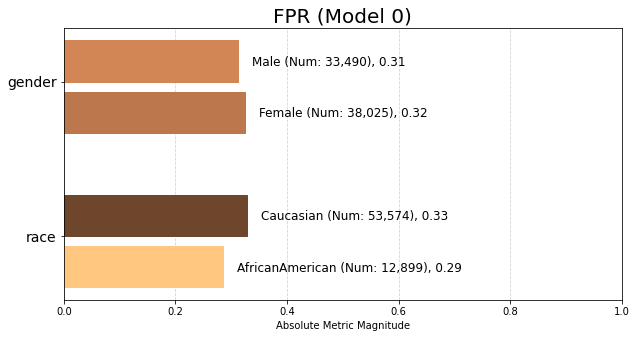

In [418]:
tpr = aqp.plot_group_metric(clean_xtab, 'tpr', min_group_size=0.05)
tpr = aqp.plot_group_metric(clean_xtab, 'fpr', min_group_size=0.05)

### False Positive Rate(Race)

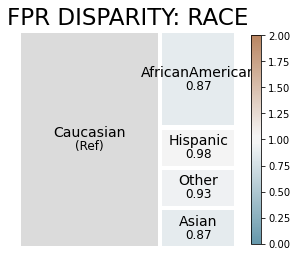

In [419]:
fpr_disparity = aqp.plot_disparity(fdf, group_metric='fpr_disparity', 
                                       attribute_name='race')

In order to deploy  the model in a business healthcare environment or as a product for a device, we have to define for which groups the model can be used. 

In this Caucasian is being use as a **group of reference**, in comparison with the  other categories it is relative **fair** for false positive rate, it means the model have a similar rate in each **demographic group**.